# Aprendizado por Reforço

- Bruno Pilão - 202201037911
- Mateus Norcia - 202201038381
- Isabelle Mamprim - 202109123289


Este trabalho tem como objetivo aplicar os conceitos fundamentais de Aprendizado por Reforço (Reinforcement Learning) através da modelagem de um Processo de Decisão de Markov (MDP), utilizando o ambiente Taxi-v3 disponível na biblioteca Gymnasium.

O ambiente simula um cenário onde um táxi deve buscar um passageiro em um ponto específico e levá-lo até o destino correto, dentro de um grid (5x5) com obstáculos e paredes. O agente (táxi) aprende a agir por tentativa e erro, buscando maximizar a recompensa acumulada com base nas ações tomadas.

![Ambiente Taxi-v3](img/enviroment_taxi.png)



## 🧩 Definição do Markov Decision Process


### Estados (S):
- O ambiente tem 500 estados possíveis. Cada estado representa:
- Posição do táxi (fila, coluna)
- Local de origem do passageiro (uma das 5 localizações fixas)
    - 0: Vermelho
    - 1: Verde
    - 2: Amarelo
    - 3: Azul
    - 4: No taxi

### Ações (A):
- 0 = Mover para sul
- 1 = Mover para norte
- 2 = Mover para leste
- 3 = Mover para oeste
- 4 = Pegar passageiro
- 5 = Deixar passageiro

### Recompensas
- R(s, a) = −1 por passo.
- Estados (0,1);(0,4);(4,1);(3,4) são terminais com recompensa +20 (depedendo da Localização do Hotel).
- Estado tem recompensa negativa −10, por executar indevidamente as ações de embarque e desembarque.
### Transições (P(s'|s,a)):
Determinísticas, exceto quando o táxi tenta atravessar uma parede, nesse caso, ele permanece no mesmo estado.

### Recompensas

- -1 Movimento do Taxi.
- +20 Despachar passageiro corretamente.
- -10 Buscar / Despachar passageiro corretamente.


In [1]:
!python --version

Python 3.13.3


In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [3]:
# Criando o ambiente Taxi-v3
env_default = gym.make("Taxi-v3",render_mode='rgb_array')
env_raining = gym.make("Taxi-v3",is_rainy=True,render_mode='rgb_array')

## Equação de Bellman


In [4]:
# Teste de funcao de Bellman
print("Ambiente Default",env_default.action_space.n, env_default.observation_space.n)
print("Ambiente Raining",env_raining.action_space.n, env_raining.observation_space.n)

Ambiente Default 6 500
Ambiente Raining 6 500


In [6]:
def aplicar_bellman(env, gamma=0.9, theta=1e-6):
    """
    Aplica a Equação de Bellman (Value Iteration) a um ambiente Gym.
    Retorna V(s) e um DataFrame com o histórico de convergência.
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    V = np.zeros(n_states)
    history = []
    iter_count = 0

    def bellman_update(V):
        delta = 0
        for s in range(n_states):
            v = V[s]
            values = []
            for a in range(n_actions):
                q_sa = 0
                for prob, next_state, reward, done in env.unwrapped.P[s][a]:
                    q_sa += prob * (reward + gamma * V[next_state] * (not done))
                    # print(f"Estado: {s}, Ação: {a}, Próximo Estado: {next_state}, Recompensa: {reward}, Probabilidade: {prob}, Done: {done}")
                values.append(q_sa)
            V[s] = max(values)
            delta = max(delta, abs(v - V[s]))
        
        return V, delta

    while True:
        V, delta = bellman_update(V)
        iter_count += 1
        history.append({
            "Iteracao": iter_count,
            "Valor Médio": np.mean(V),
            "Valor Máximo": np.max(V),
            "Delta": delta,
            "V": V.copy()
            
            
        })
        if delta < theta:
            break

    df = pd.DataFrame(history)
    return df


In [7]:
print("Aplicando Bellman ao ambiente padrão...")    
df_default = aplicar_bellman(env_default)

print("Aplicando Bellman ao ambiente com chuva...")
df_raining = aplicar_bellman(env_raining)

Aplicando Bellman ao ambiente padrão...
Aplicando Bellman ao ambiente com chuva...


## Plots de Visualização


In [11]:
def plot_evolucao_V(dataset,title):
    """
    Funcao para plotar a evolução de V(s) ao longo dos Iterações
    """

    # Configurações de estilo do seaborn
    sns.set_theme(style="whitegrid", context="talk")

    # Tamanho da figura
    plt.figure(figsize=(22, 10))

    # Paleta clara e equilibrada (husl tem bom contraste)
    palette = sns.color_palette("husl", n_colors=len(dataset))

    # Valor do deslocamento vertical entre Iterações
    offset = 3.0  

    # Plotando cada episódio com suavização e deslocamento
    for i in range(len(dataset)):
        v_raw = pd.Series(dataset["V"][i])
        # suaviza um pouco mais
        v_smooth = v_raw.rolling(window=8, center=True, min_periods=1).mean()

        # aplica deslocamento vertical para separar visualmente as curvas
        v_data = pd.DataFrame({
            "Estado": range(len(v_smooth)),
            "Valor": v_smooth + (i * offset)
        })

        sns.lineplot(
            data=v_data,
            x="Estado",
            y="Valor",
            color=palette[i],
            linewidth=2.0,
            alpha=0.75,
            label=f"Iteração {i+1}"
        )


    # Customizações 
    plt.title(f"Evolução de V(s) — Ambiente {title} ", fontsize=22, pad=25, weight="bold")
    plt.xlabel("Estado (s)", fontsize=16)
    plt.ylabel("Valor de V(s) (com deslocamento visual)", fontsize=16)

    # Legenda lateral organizada
    plt.legend(
        title="Iterações",
        bbox_to_anchor=(1,1),
        loc='upper left',
        fontsize=12,
        frameon=True,
        framealpha=0.9
    )

    # Grade e espaçamento
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.margins(y=0.1)
    plt.tight_layout()
    plt.show()
    
    # Printando valor medio por episodio
    for i in range(len(dataset)):
        print(f"Iteração {i+1}: Valor médio de V(s) = {dataset['Valor Médio'][i]:.4f}")


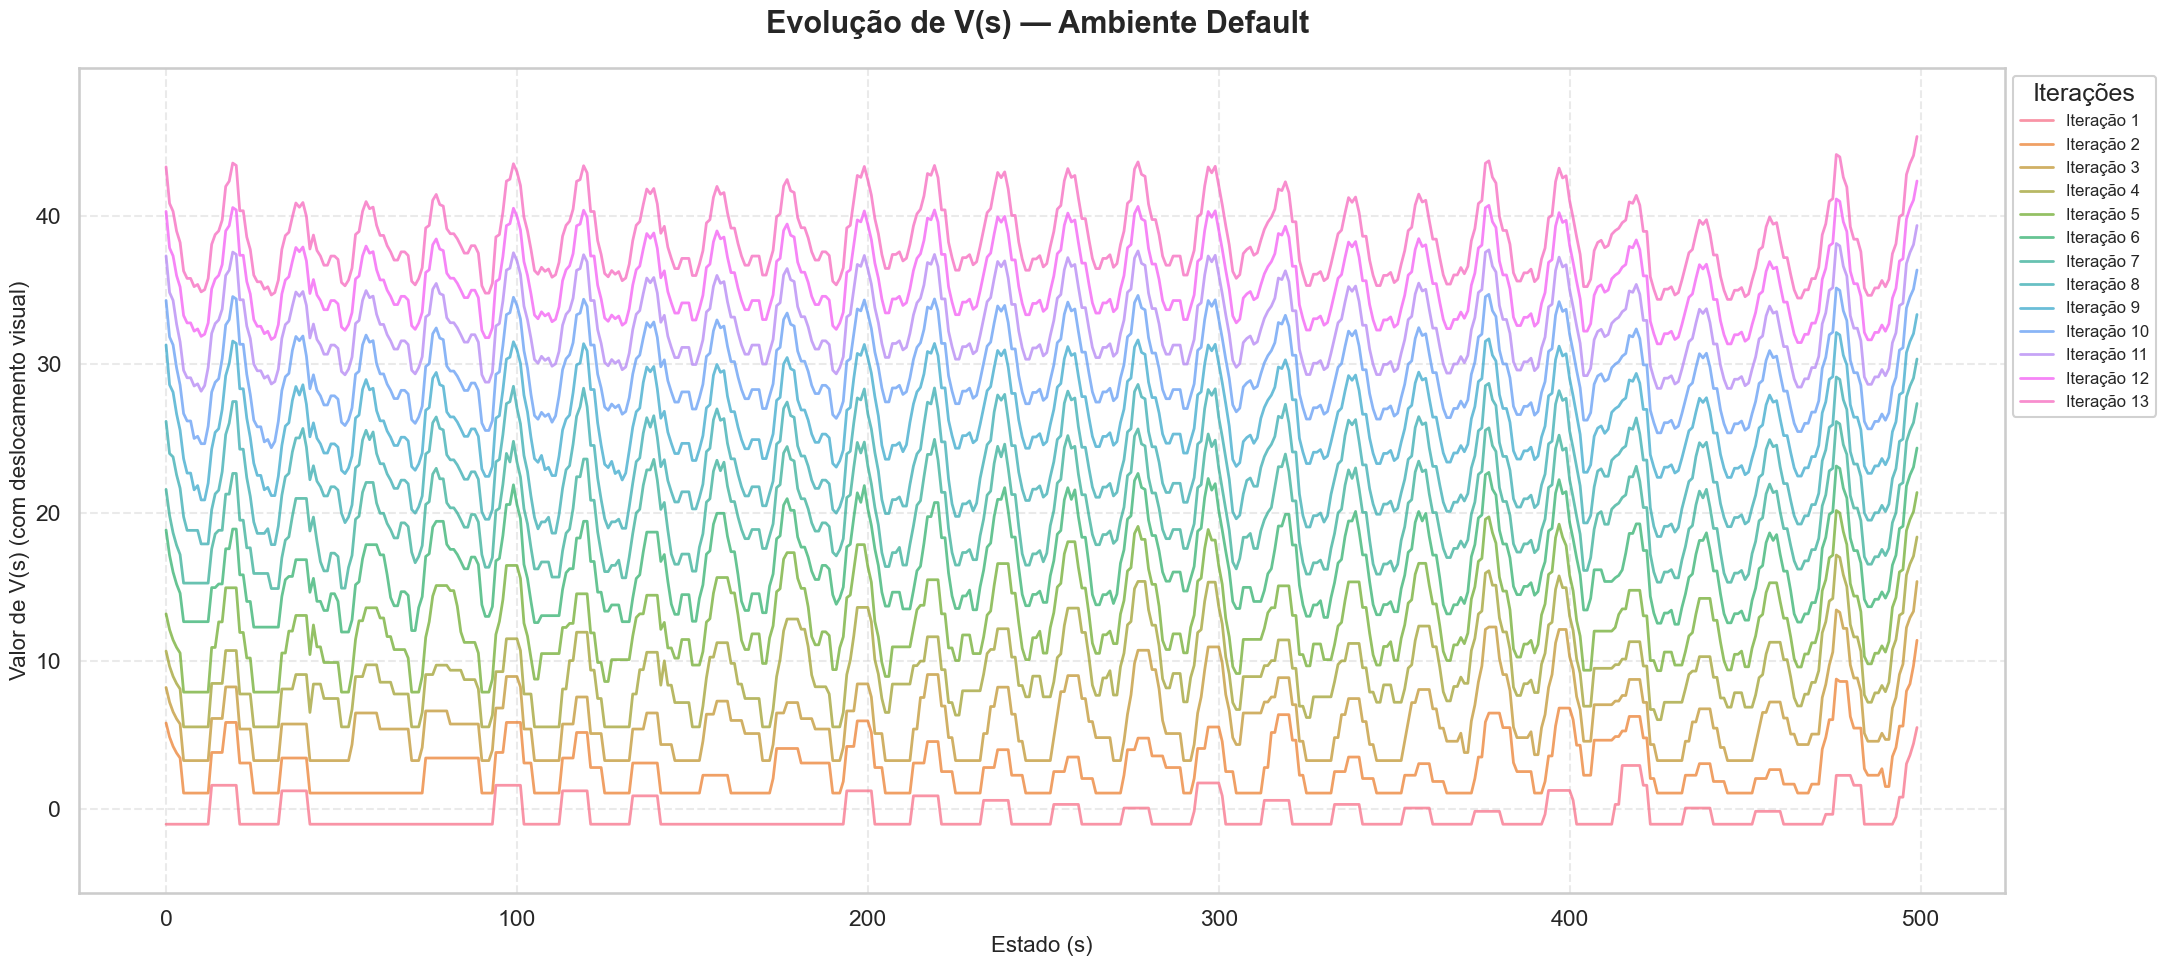

Iteração 1: Valor médio de V(s) = -0.3103
Iteração 2: Valor médio de V(s) = -0.2096
Iteração 3: Valor médio de V(s) = -0.0810
Iteração 4: Valor médio de V(s) = 0.2940
Iteração 5: Valor médio de V(s) = 0.6029
Iteração 6: Valor médio de V(s) = 1.2522
Iteração 7: Valor médio de V(s) = 1.5183
Iteração 8: Valor médio de V(s) = 1.8749
Iteração 9: Valor médio de V(s) = 2.2299
Iteração 10: Valor médio de V(s) = 2.3771
Iteração 11: Valor médio de V(s) = 2.4567
Iteração 12: Valor médio de V(s) = 2.4679
Iteração 13: Valor médio de V(s) = 2.4679


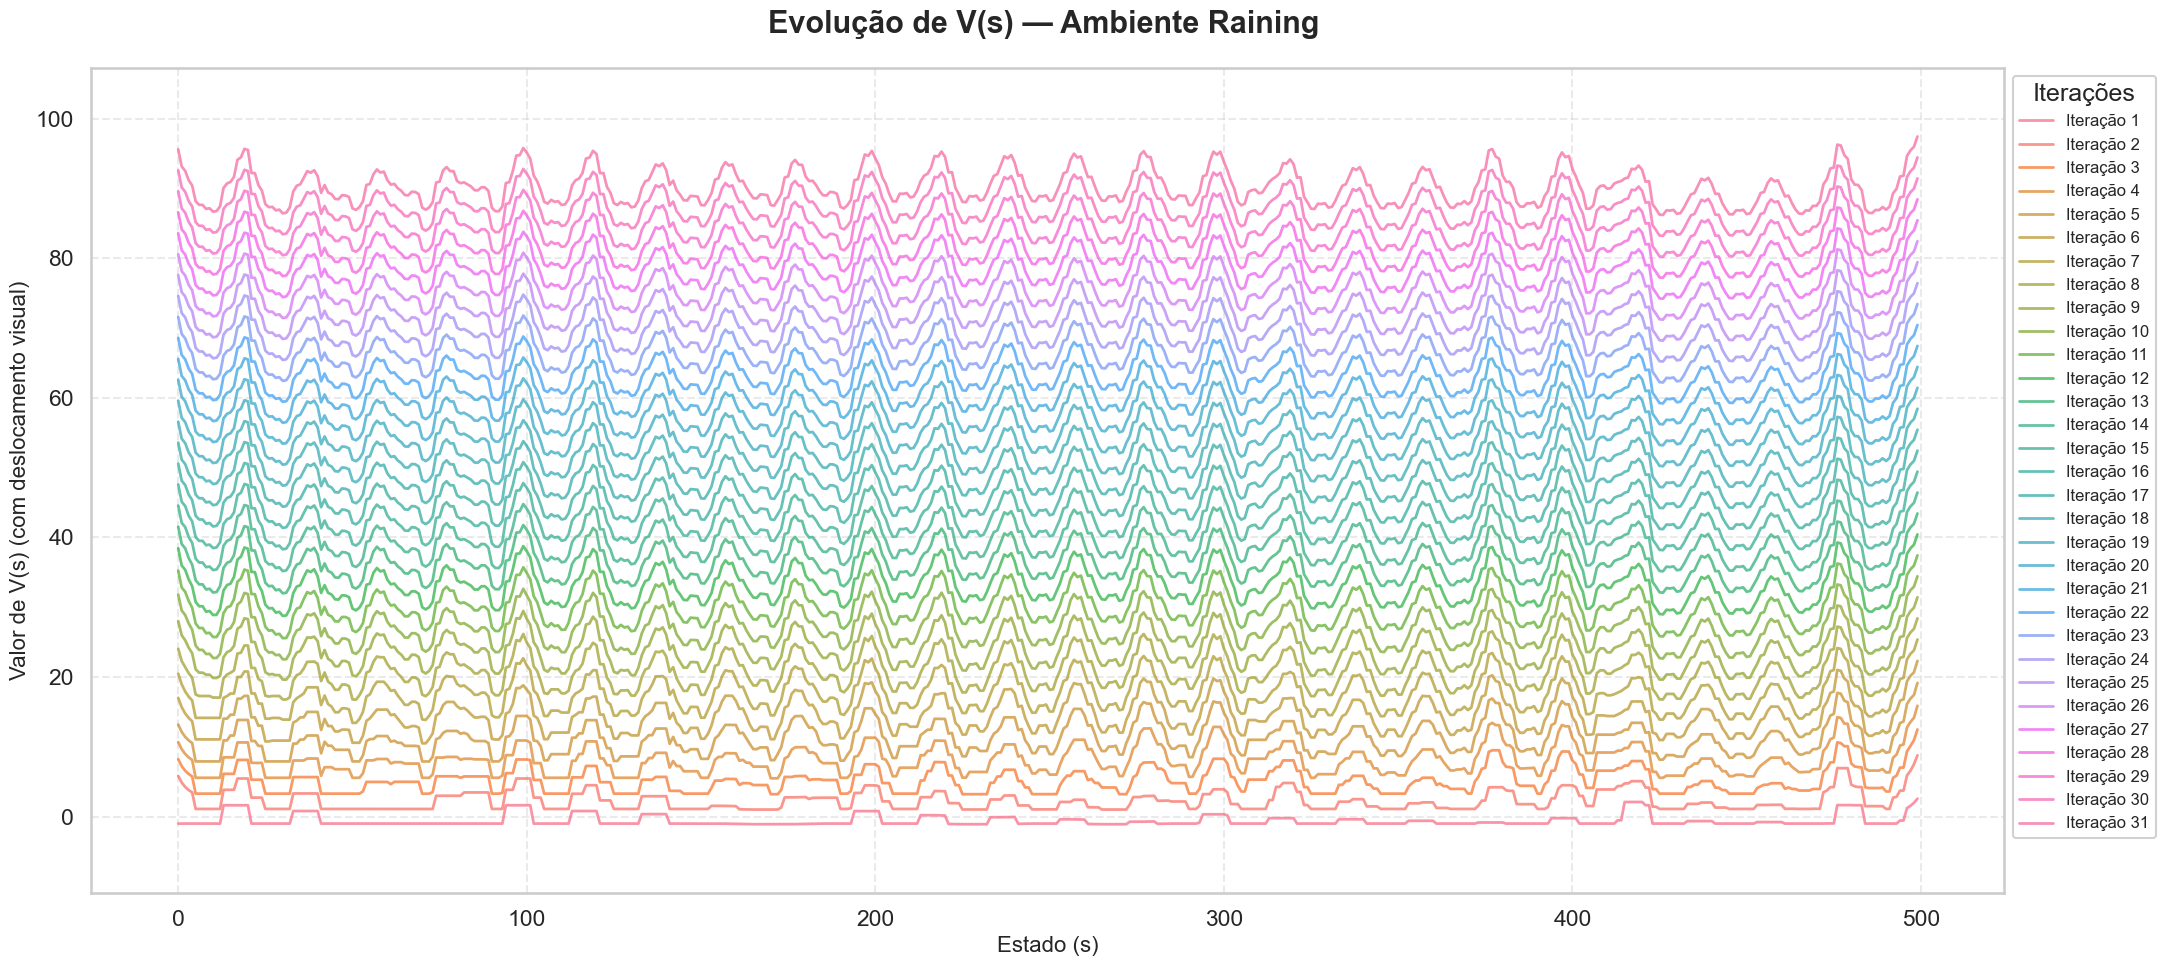

Iteração 1: Valor médio de V(s) = -0.5664
Iteração 2: Valor médio de V(s) = -0.7252
Iteração 3: Valor médio de V(s) = -0.8601
Iteração 4: Valor médio de V(s) = -0.8892
Iteração 5: Valor médio de V(s) = -0.8305
Iteração 6: Valor médio de V(s) = -0.6801
Iteração 7: Valor médio de V(s) = -0.5102
Iteração 8: Valor médio de V(s) = -0.3643
Iteração 9: Valor médio de V(s) = -0.2417
Iteração 10: Valor médio de V(s) = -0.1292
Iteração 11: Valor médio de V(s) = -0.0215
Iteração 12: Valor médio de V(s) = 0.0753
Iteração 13: Valor médio de V(s) = 0.1501
Iteração 14: Valor médio de V(s) = 0.1994
Iteração 15: Valor médio de V(s) = 0.2280
Iteração 16: Valor médio de V(s) = 0.2431
Iteração 17: Valor médio de V(s) = 0.2506
Iteração 18: Valor médio de V(s) = 0.2540
Iteração 19: Valor médio de V(s) = 0.2556
Iteração 20: Valor médio de V(s) = 0.2562
Iteração 21: Valor médio de V(s) = 0.2565
Iteração 22: Valor médio de V(s) = 0.2566
Iteração 23: Valor médio de V(s) = 0.2567
Iteração 24: Valor médio de V(s)

In [12]:
# Plotando a evolução de V(s) para o ambiente padrão
plot_evolucao_V(df_default,"Default")

# Plotando a evolução de V(s) para o ambiente com chuva
plot_evolucao_V(df_raining,"Raining")

## Algoritimos


In [13]:
# Função de política epsilon-greedy

import random

def politica_epsilon_greedy(Q, estado, n_acoes, epsilon=0.1):
    """
    Função de política epsilon-greedy com objetivo de exploration e exploitation
    
    Exploration: Com probabilidade epsilon, escolhe uma ação aleatória. (Tentar novas ações)
    Exploitation: Com probabilidade 1 - epsilon, escolhe a ação com maior valor Q. (Tirar proveito do conhecimento atual)
    """
    
    if random.random() < epsilon:
        return random.randint(0, n_acoes - 1)
    return np.argmax(Q[estado])


### Algoritimo de Monte Carlo


In [14]:
def monte_carlo_first_visit(env, num_episodes=5000, gamma=0.99, epsilon=0.1):
    """
    
    """
    from collections import defaultdict

    # calcula V* via aplicar_bellman e deriva Q* a partir de V*
    df_bellman = aplicar_bellman(env, gamma)
    V_opt = np.array(df_bellman["V"].iloc[-1])  # V* estimado (última iteração)
    nS, nA = env.observation_space.n, env.action_space.n

    Q_opt = np.zeros((nS, nA))
    for s in range(nS):
        for a in range(nA):
            q_sa = 0.0
            for prob, next_state, reward, done in env.unwrapped.P[s][a]:
                q_sa += prob * (reward + gamma * V_opt[next_state] * (not done))
            Q_opt[s, a] = q_sa

    soma_retornos     = defaultdict(float)
    contagem_retornos = defaultdict(int)
    Q                 = defaultdict(lambda: np.zeros(nA))
    erros             = []

    for ep in range(num_episodes):
        episodio = []
        s, _ = env.reset()
        done = False
        while not done:
            a = politica_epsilon_greedy(Q,s,nA,epsilon)
            s2, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            episodio.append((s, a, r))
            s = s2

        G = 0.0
        visitados = set()
        for (s, a, r) in reversed(episodio):
            G = gamma * G + r
            if (s, a) not in visitados:
                soma_retornos[(s, a)] += G
                contagem_retornos[(s, a)] += 1
                Q[s][a] = soma_retornos[(s, a)] / contagem_retornos[(s, a)]
                visitados.add((s, a))

        # erro médio vs Q* (apenas estados/ações discretos)
        diffs = []
        for s_idx in range(nS):
            for a_idx in range(nA):
                diffs.append(abs(Q[s_idx][a_idx] - Q_opt[s_idx, a_idx]))
        erros.append(np.mean(diffs))

    return Q, erros

In [15]:
def monte_carlo_every_visit(env, num_episodes=5000, gamma=0.99, epsilon=0.1):
    """
  
    """
    from collections import defaultdict

    # calcula V* via aplicar_bellman e deriva Q* a partir de V*
    df_bellman = aplicar_bellman(env, gamma)
    V_opt = np.array(df_bellman["V"].iloc[-1])  # V* estimado (última iteração)
    nS, nA = env.observation_space.n, env.action_space.n

    Q_opt = np.zeros((nS, nA))
    for s in range(nS):
        for a in range(nA):
            q_sa = 0.0
            for prob, next_state, reward, done in env.unwrapped.P[s][a]:
                q_sa += prob * (reward + gamma * V_opt[next_state] * (not done))
            Q_opt[s, a] = q_sa

    soma_retornos     = defaultdict(float)
    contagem_retornos = defaultdict(int)
    Q                 = defaultdict(lambda: np.zeros(nA))
    erros             = []

    
    for ep in range(num_episodes):
        episodio = []
        s, _ = env.reset()
        done = False

        # Gera um episódio
        while not done:
            a  = politica_epsilon_greedy(Q, s,nA,epsilon)
            s2, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            episodio.append((s, a, r))
            s = s2

        # Every-Visit MC update
        G = 0.0
        for (s, a, r) in reversed(episodio):
            G = gamma * G + r
            soma_retornos[(s, a)]    += G
            contagem_retornos[(s, a)] += 1
            Q[s][a] = soma_retornos[(s, a)] / contagem_retornos[(s, a)]

        # erro médio vs Q*
        diffs = []
        for s_idx in range(nS):
            for a_idx in range(nA):
                diffs.append(abs(Q[s_idx][a_idx] - Q_opt[s_idx, a_idx]))
        erros.append(np.mean(diffs))

    return Q, erros


### Algoritomo Q-Learining

O Q-Learning é um algoritmo de aprendizado por reforço off-policy. Ele aprende a função de valor-ação \( Q(s, a) \) usando a equação de atualização:

$
Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right]
$

Diferente do SARSA (on-policy), que usa a ação realmente tomada no próximo estado, o Q-Learning usa a **melhor ação possível** (\( \max Q \)) independentemente da política seguida. Isso tende a favorecer a exploração de políticas mais eficientes.


In [16]:
def q_learning(env, num_episodes=700, max_steps=200, alpha=0.1, gamma=0.9, epsilon=0.1, start_reward=10):
    """
    Q-learning tabular para ambientes discretos (Taxi-v3).
    Retorna a tabela Q e a lista de erros médios por episódio (comparação com Q*).
    """
   
    df_bellman = aplicar_bellman(env, gamma)
    V_opt = np.array(df_bellman["V"].iloc[-1])
    nS, nA = env.observation_space.n, env.action_space.n

    Q_opt = np.zeros((nS, nA))
    for s in range(nS):
        for a in range(nA):
            q_sa = 0.0
            for prob, next_state, reward, done in env.unwrapped.P[s][a]:
                q_sa += prob * (reward + gamma * V_opt[next_state] * (not done))
            Q_opt[s, a] = q_sa

    Q = np.zeros((nS, nA))
    erros = []
    episode_rewards = []

    for ep in range(num_episodes):
        obs, info = env.reset()
        total_reward = start_reward

        for t in range(max_steps):
            # Epsilon-greedy
            a = politica_epsilon_greedy(Q, obs, nA, epsilon)
            next_obs, reward, terminated, truncated, info = env.step(a)
            done = terminated or truncated

            # Q-learning update (off-policy)
            best_next = np.max(Q[next_obs])
            Q[obs, a] = Q[obs, a] + alpha * (reward + gamma * best_next * (not done) - Q[obs, a])
            obs = next_obs
            total_reward += reward
            if done:
                break

        episode_rewards.append(total_reward)

        # erro médio vs Q*
        diffs = []
        for s_idx in range(nS):
            for a_idx in range(nA):
                diffs.append(abs(Q[s_idx, a_idx] - Q_opt[s_idx, a_idx]))
        erros.append(np.mean(diffs))

    return Q, erros

In [17]:
def q_policy(Q):
    """
    Deriva uma política a partir da tabela Q.
    """
    return np.argmax(Q, axis=1)

### Algoritmo SARSA

Atualização baseada na ação efetivamente tomada:

$ Q(s, a) \leftarrow Q(s, a) + \alpha [r + \gamma Q(s', a') - Q(s, a)] $

In [18]:
def sarsa(env, num_episodes=5000, gamma=0.99, alpha=0.1, epsilon=0.1):
    """
    SARSA (on-policy) usando a política politica_epsilon_greedy e
    comparando erro médio contra Q* derivado de aplicar_bellman.
    """
    from collections import defaultdict

    # calcula V* via aplicar_bellman e deriva Q* a partir de V*
    df_bellman = aplicar_bellman(env, gamma)
    V_opt = np.array(df_bellman["V"].iloc[-1])
    nS, nA = env.observation_space.n, env.action_space.n

    Q_opt = np.zeros((nS, nA))
    for s in range(nS):
        for a in range(nA):
            q_sa = 0.0
            for prob, next_state, reward, done in env.unwrapped.P[s][a]:
                q_sa += prob * (reward + gamma * V_opt[next_state] * (not done))
            Q_opt[s, a] = q_sa

    Q = defaultdict(lambda: np.zeros(nA))
    erros = []

    for ep in range(num_episodes):
        s, _ = env.reset()
        a = politica_epsilon_greedy(Q, s, nA, epsilon)
        done = False
        while not done:
            s2, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            a2 = politica_epsilon_greedy(Q, s2, nA, epsilon)

            target = r + gamma * Q[s2][a2] * (not done)
            Q[s][a] += alpha * (target - Q[s][a])
            s, a = s2, a2

        # erro médio vs Q*
        diffs = []
        for s_idx in range(nS):
            for a_idx in range(nA):
                diffs.append(abs(Q[s_idx][a_idx] - Q_opt[s_idx, a_idx]))
        erros.append(np.mean(diffs))

    return Q, erros


### Comparativo de Algoritimos


In [19]:

import time

# Parâmetros globais
GAMMA = 0.99
ALPHA = 0.1
EPSILON = 0.1
MAX_STEPS = 200
EPISODIOS = 3000

def comparativo_algoritmos(env,ambiente_nome):
    """
    Compara os algoritmos Monte Carlo First-Visit, Monte Carlo Every-Visit,
    SARSA e Q-Learning em termos de convergência e tempo de execução.
    Plota os erros médios estimados ao longo dos episódios.
    """
    print("=-"*10)
    print(f"Comparativo de Algoritmos no Ambiente {ambiente_nome}")
    print("=-"*10)
    # Lista de Timer de Execução
    times = {}

    start = time.time()
    Q_mc, erro_mc = monte_carlo_first_visit(env,num_episodes=EPISODIOS)
    times['Monte Carlo First-Visit'] = time.time() - start

    start = time.time()
    Q_mc_every, erro_mc_every = monte_carlo_every_visit(env,num_episodes=EPISODIOS)
    times['Monte Carlo Every-Visit'] = time.time() - start


    start = time.time()
    Q_sarsa, erro_sarsa = sarsa(env, num_episodes=EPISODIOS)
    times['SARSA'] = time.time() - start

    start = time.time()
    Q_q, erro_q = q_learning(env,num_episodes=EPISODIOS)
    times['Q-Learning'] = time.time() - start

    # Plotando
    plt.figure(figsize=(10, 6))
    plt.plot(erro_mc_every, label='Monte Carlo Every-Visit')
    plt.plot(erro_mc, label='Monte Carlo First-Visit')
    plt.plot(erro_sarsa, label='SARSA')
    plt.plot(erro_q, label='Q-Learning')
    plt.xlabel('Episódios')
    plt.ylabel('Erro Médio Estimado')
    plt.title('Comparação de Convergência')
    plt.legend()
    plt.grid(True)
    plt.show()

    for alg, t in times.items():
        print(f"{alg}: {t:.2f} segundos")
        
    print("\n")


=-=-=-=-=-=-=-=-=-=-
Comparativo de Algoritmos no Ambiente Default
=-=-=-=-=-=-=-=-=-=-


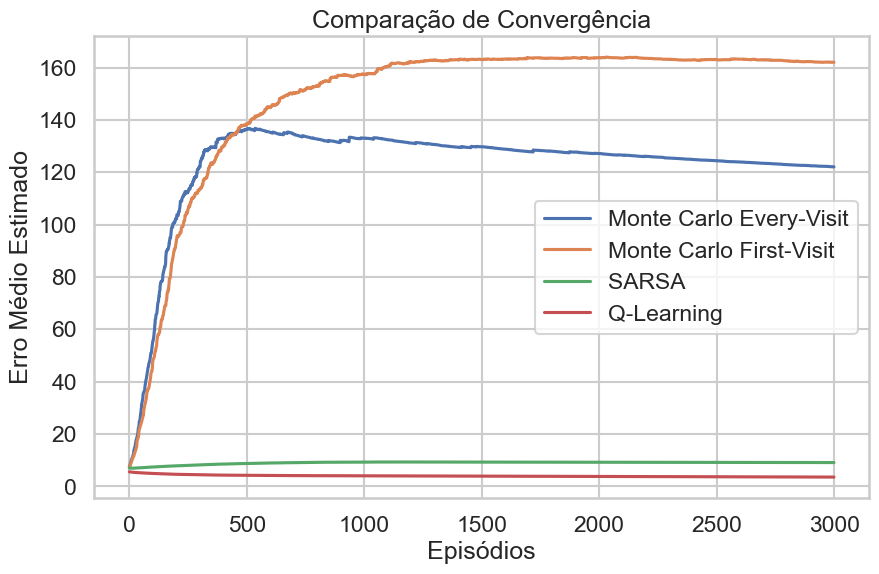

Monte Carlo First-Visit: 11.91 segundos
Monte Carlo Every-Visit: 12.22 segundos
SARSA: 5.64 segundos
Q-Learning: 6.13 segundos


=-=-=-=-=-=-=-=-=-=-
Comparativo de Algoritmos no Ambiente Raining
=-=-=-=-=-=-=-=-=-=-


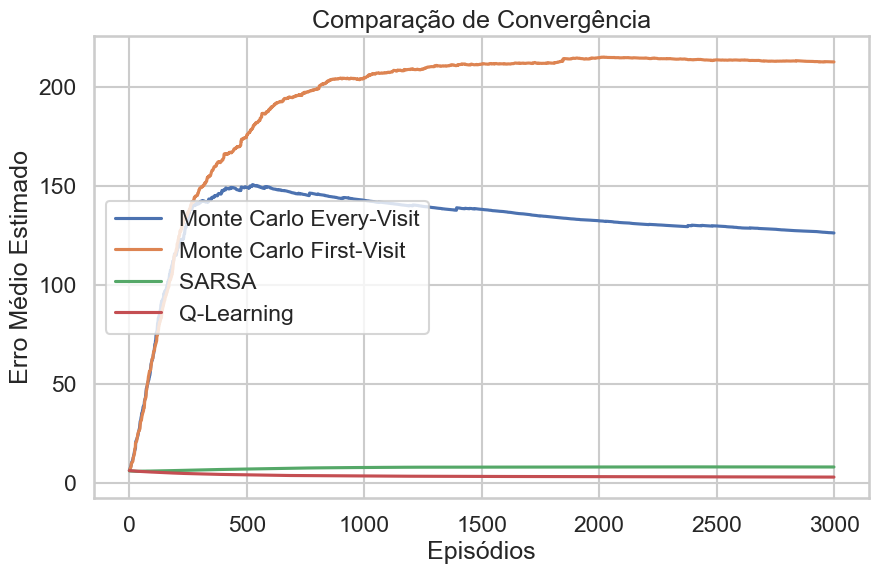

Monte Carlo First-Visit: 12.62 segundos
Monte Carlo Every-Visit: 12.83 segundos
SARSA: 6.67 segundos
Q-Learning: 7.10 segundos




In [20]:
comparativo_algoritmos(env_default,"Default")
comparativo_algoritmos(env_raining,"Raining")

## Treinanmento de Agente 

Nesta etapa vamos implemetar o treinamento de nosso agente de IA no qual deve implementer os algoritomos de política


In [21]:
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo
import numpy as np


def avaliar_agente_gymnasium(
        environment,
        env_name,
        Q,
        erros,
        num_eval_episodes=5,
        video_folder="videos",
        politica_nome="Agente"
    ):
    """
    Versão adaptada do exemplo oficial do Gymnasium usando Q + epsilon baseado no erro.
    """

    print(f"\n🎥 Iniciando avaliação do agente `{politica_nome}`")
    print(f"Ambiente: {env_name}")
    print(f"Episódios: {num_eval_episodes}")
    print(f"Salvar vídeos em: {video_folder}/\n")

    # epsilon baseado no erro
    erro_final = float(erros[-1])
    epsilon = max(0.01, min(0.20, erro_final))  # clamp
    print(f"ε (erro final do treinamento) = {epsilon:.4f}\n")

    

    # grava TODOS os episódios
    env = RecordVideo(
        environment,
        video_folder=video_folder,
        name_prefix=f"{politica_nome}",
        episode_trigger=lambda ep: True
    )

    # estatísticas dos episódios
    env = RecordEpisodeStatistics(env, buffer_length=num_eval_episodes)

    def escolher_acao(Q, s, epsilon):
        """Ação epsilon-greedy usando Q aprendido."""
        if np.random.rand() < epsilon:
            return np.random.randint(len(Q[int(s)]))  # exploração mínima
        return int(np.argmax(Q[int(s)]))

    # loop principal igual ao exemplo oficial
    for episode_num in range(num_eval_episodes):

        s, info = env.reset()
        s = int(s)

        episode_reward = 10
        step_count = 0
        episode_over = False

        while not episode_over:

            # ação da política aprendida
            action = escolher_acao(Q, s, epsilon)

            s2, reward, terminated, truncated, info = env.step(action)
            s = int(s2)

            episode_reward += reward
            step_count += 1
            episode_over = terminated or truncated

        print(f"🌟 Episódio {episode_num + 1}: {step_count} steps — recompensa = {episode_reward}")

    env.close()

    # Resumo final idêntico ao exemplo oficial
    print(f'\n📊 Evaluation Summary ({politica_nome}):')
    print(f'Episode durations: {list(env.time_queue)}')
    print(f'Episode rewards:   {list(env.return_queue)}')
    print(f'Episode lengths:   {list(env.length_queue)}')

    avg_reward = np.mean(env.return_queue)
    avg_length = np.mean(env.length_queue)
    std_reward = np.std(env.return_queue)

    print(f'\nMédia da recompensa: {avg_reward:.2f} ± {std_reward:.2f}')
    print(f'Média do comprimento do episódio: {avg_length:.1f} passos')
    print(f'Taxa de sucesso: {sum(1 for r in env.return_queue if r > 0) / len(env.return_queue):.1%}')



### Sarsa


In [22]:
Q_sarsa, erros_sarsa = sarsa(env_default, num_episodes=5000)

avaliar_agente_gymnasium(
    env_default,
    env_name="Taxi-v3",
    Q=Q_sarsa,
    erros=erros_sarsa,
    num_eval_episodes=100,
    video_folder="videos/default/SARSA",
    politica_nome="SARSA"
)



🎥 Iniciando avaliação do agente `SARSA`
Ambiente: Taxi-v3
Episódios: 100
Salvar vídeos em: videos/default/SARSA/

ε (erro final do treinamento) = 0.2000

🌟 Episódio 1: 20 steps — recompensa = -7
🌟 Episódio 2: 12 steps — recompensa = 19
🌟 Episódio 3: 11 steps — recompensa = 20
🌟 Episódio 4: 16 steps — recompensa = 15
🌟 Episódio 5: 13 steps — recompensa = 9
🌟 Episódio 6: 21 steps — recompensa = 1
🌟 Episódio 7: 12 steps — recompensa = 10
🌟 Episódio 8: 21 steps — recompensa = 10
🌟 Episódio 9: 16 steps — recompensa = 15
🌟 Episódio 10: 16 steps — recompensa = 6
🌟 Episódio 11: 18 steps — recompensa = 13
🌟 Episódio 12: 13 steps — recompensa = 18
🌟 Episódio 13: 20 steps — recompensa = -7
🌟 Episódio 14: 20 steps — recompensa = 2
🌟 Episódio 15: 22 steps — recompensa = 0
🌟 Episódio 16: 15 steps — recompensa = 16
🌟 Episódio 17: 19 steps — recompensa = 12
🌟 Episódio 18: 18 steps — recompensa = 13
🌟 Episódio 19: 33 steps — recompensa = -11
🌟 Episódio 20: 13 steps — recompensa = 18
🌟 Episódio 21: 21 

In [23]:
Q_sarsa, erros_sarsa = sarsa(env_raining, num_episodes=5000)

avaliar_agente_gymnasium(
    env_default,
    env_name="Taxi-v3",
    Q=Q_sarsa,
    erros=erros_sarsa,
    num_eval_episodes=100,
    video_folder="videos/raining/SARSA",
    politica_nome="SARSA"
)



🎥 Iniciando avaliação do agente `SARSA`
Ambiente: Taxi-v3
Episódios: 100
Salvar vídeos em: videos/raining/SARSA/

ε (erro final do treinamento) = 0.2000

🌟 Episódio 1: 17 steps — recompensa = 14
🌟 Episódio 2: 20 steps — recompensa = 2
🌟 Episódio 3: 15 steps — recompensa = 16
🌟 Episódio 4: 18 steps — recompensa = 13
🌟 Episódio 5: 10 steps — recompensa = 21
🌟 Episódio 6: 15 steps — recompensa = 16
🌟 Episódio 7: 18 steps — recompensa = 13
🌟 Episódio 8: 17 steps — recompensa = 14
🌟 Episódio 9: 16 steps — recompensa = 15
🌟 Episódio 10: 22 steps — recompensa = 0
🌟 Episódio 11: 20 steps — recompensa = -7
🌟 Episódio 12: 16 steps — recompensa = 15
🌟 Episódio 13: 25 steps — recompensa = -30
🌟 Episódio 14: 11 steps — recompensa = 11
🌟 Episódio 15: 22 steps — recompensa = 0
🌟 Episódio 16: 13 steps — recompensa = 18
🌟 Episódio 17: 8 steps — recompensa = 23
🌟 Episódio 18: 15 steps — recompensa = 7
🌟 Episódio 19: 18 steps — recompensa = 4
🌟 Episódio 20: 13 steps — recompensa = 9
🌟 Episódio 21: 10 st

### Q-Learning


In [25]:
Q_q, erros_q = q_learning(env_raining, num_episodes=5000)

avaliar_agente_gymnasium(
    env_default,
    env_name="Taxi-v3",
    Q=Q_sarsa,
    erros=erros_q,
    num_eval_episodes=100,
    video_folder="videos/raining/q_learning",
    politica_nome="Q-Learning"
)



🎥 Iniciando avaliação do agente `Q-Learning`
Ambiente: Taxi-v3
Episódios: 100
Salvar vídeos em: videos/raining/q_learning/

ε (erro final do treinamento) = 0.2000

🌟 Episódio 1: 14 steps — recompensa = 8
🌟 Episódio 2: 11 steps — recompensa = 11
🌟 Episódio 3: 18 steps — recompensa = -14
🌟 Episódio 4: 12 steps — recompensa = 19
🌟 Episódio 5: 19 steps — recompensa = 3
🌟 Episódio 6: 19 steps — recompensa = -6
🌟 Episódio 7: 16 steps — recompensa = 6
🌟 Episódio 8: 16 steps — recompensa = 6
🌟 Episódio 9: 24 steps — recompensa = -29
🌟 Episódio 10: 16 steps — recompensa = -3
🌟 Episódio 11: 15 steps — recompensa = 16
🌟 Episódio 12: 14 steps — recompensa = 8
🌟 Episódio 13: 14 steps — recompensa = 17
🌟 Episódio 14: 19 steps — recompensa = -6
🌟 Episódio 15: 15 steps — recompensa = 16
🌟 Episódio 16: 8 steps — recompensa = 14
🌟 Episódio 17: 14 steps — recompensa = 17
🌟 Episódio 18: 17 steps — recompensa = -13
🌟 Episódio 19: 16 steps — recompensa = 15
🌟 Episódio 20: 15 steps — recompensa = 16
🌟 Episó

In [26]:
Q_q, erros_q = q_learning(env_default, num_episodes=5000)

avaliar_agente_gymnasium(
    env_default,
    env_name="Taxi-v3",
    Q=Q_sarsa,
    erros=erros_q,
    num_eval_episodes=100,
    video_folder="videos/default/q_learning",
    politica_nome="Q-Learning"
)



🎥 Iniciando avaliação do agente `Q-Learning`
Ambiente: Taxi-v3
Episódios: 100
Salvar vídeos em: videos/default/q_learning/

ε (erro final do treinamento) = 0.2000

🌟 Episódio 1: 13 steps — recompensa = 18
🌟 Episódio 2: 16 steps — recompensa = 15
🌟 Episódio 3: 7 steps — recompensa = 24
🌟 Episódio 4: 14 steps — recompensa = 8
🌟 Episódio 5: 22 steps — recompensa = -9
🌟 Episódio 6: 18 steps — recompensa = 13
🌟 Episódio 7: 20 steps — recompensa = 2
🌟 Episódio 8: 18 steps — recompensa = -5
🌟 Episódio 9: 11 steps — recompensa = 20
🌟 Episódio 10: 23 steps — recompensa = -19
🌟 Episódio 11: 18 steps — recompensa = 4
🌟 Episódio 12: 17 steps — recompensa = 5
🌟 Episódio 13: 22 steps — recompensa = 0
🌟 Episódio 14: 25 steps — recompensa = -21
🌟 Episódio 15: 15 steps — recompensa = 16
🌟 Episódio 16: 17 steps — recompensa = 5
🌟 Episódio 17: 18 steps — recompensa = 4
🌟 Episódio 18: 15 steps — recompensa = 7
🌟 Episódio 19: 10 steps — recompensa = 21
🌟 Episódio 20: 14 steps — recompensa = 17
🌟 Episódio 

### First Visit

In [30]:
Q_first, erros_first = monte_carlo_first_visit(env_raining, num_episodes=5000)


avaliar_agente_gymnasium(
    env_default,
    env_name="Taxi-v3",
    Q=Q_first,
    erros=erros_first,
    num_eval_episodes=100,
    video_folder="videos/default/first_visit",
    politica_nome="First Visit"
)



🎥 Iniciando avaliação do agente `First Visit`
Ambiente: Taxi-v3
Episódios: 100
Salvar vídeos em: videos/default/first_visit/

ε (erro final do treinamento) = 0.2000

🌟 Episódio 1: 200 steps — recompensa = -334
🌟 Episódio 2: 200 steps — recompensa = -847
🌟 Episódio 3: 200 steps — recompensa = -433
🌟 Episódio 4: 200 steps — recompensa = -955
🌟 Episódio 5: 200 steps — recompensa = -280
🌟 Episódio 6: 200 steps — recompensa = -397
🌟 Episódio 7: 200 steps — recompensa = -415
🌟 Episódio 8: 200 steps — recompensa = -1171
🌟 Episódio 9: 200 steps — recompensa = -307
🌟 Episódio 10: 200 steps — recompensa = -1225
🌟 Episódio 11: 200 steps — recompensa = -1090
🌟 Episódio 12: 200 steps — recompensa = -568
🌟 Episódio 13: 200 steps — recompensa = -667
🌟 Episódio 14: 200 steps — recompensa = -343
🌟 Episódio 15: 200 steps — recompensa = -640
🌟 Episódio 16: 200 steps — recompensa = -1720
🌟 Episódio 17: 200 steps — recompensa = -262
🌟 Episódio 18: 200 steps — recompensa = -325
🌟 Episódio 19: 200 steps — r

In [29]:
Q_first, erros_first = monte_carlo_first_visit(env_raining, num_episodes=5000)

avaliar_agente_gymnasium(
    env_raining,
    env_name="Taxi-v3",
    Q=Q_first,
    erros=erros_first,
    num_eval_episodes=100,
    video_folder="videos/raining/first_visit",
    politica_nome="First Visit"
)



🎥 Iniciando avaliação do agente `First Visit`
Ambiente: Taxi-v3
Episódios: 100
Salvar vídeos em: videos/raining/first_visit/

ε (erro final do treinamento) = 0.2000



c:\Users\bruno\OneDrive\Desktop\gith\ap1_ibmec_aprendizado_reforco\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at c:\Users\bruno\OneDrive\Desktop\gith\ap1_ibmec_aprendizado_reforco\videos\raining\first_visit folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


🌟 Episódio 1: 200 steps — recompensa = -1720
🌟 Episódio 2: 200 steps — recompensa = -307
🌟 Episódio 3: 200 steps — recompensa = -1342
🌟 Episódio 4: 200 steps — recompensa = -343
🌟 Episódio 5: 200 steps — recompensa = -469
🌟 Episódio 6: 200 steps — recompensa = -1648
🌟 Episódio 7: 200 steps — recompensa = -730
🌟 Episódio 8: 200 steps — recompensa = -937
🌟 Episódio 9: 200 steps — recompensa = -334
🌟 Episódio 10: 200 steps — recompensa = -658
🌟 Episódio 11: 200 steps — recompensa = -1126
🌟 Episódio 12: 200 steps — recompensa = -334
🌟 Episódio 13: 200 steps — recompensa = -1738
🌟 Episódio 14: 200 steps — recompensa = -361
🌟 Episódio 15: 200 steps — recompensa = -271
🌟 Episódio 16: 200 steps — recompensa = -1351
🌟 Episódio 17: 200 steps — recompensa = -280
🌟 Episódio 18: 200 steps — recompensa = -235
🌟 Episódio 19: 200 steps — recompensa = -739
🌟 Episódio 20: 200 steps — recompensa = -622
🌟 Episódio 21: 200 steps — recompensa = -964
🌟 Episódio 22: 200 steps — recompensa = -226
🌟 Episódio 23

### Every Visit


In [32]:
Q_every, erros_every = monte_carlo_every_visit(env_default, num_episodes=5000)

avaliar_agente_gymnasium(
    env_default,
    env_name="Taxi-v3",
    Q=Q_every,
    erros=erros_every,
    num_eval_episodes=100,
    video_folder="videos/default/every_visit",
    politica_nome="Every Visit"
)



🎥 Iniciando avaliação do agente `Every Visit`
Ambiente: Taxi-v3
Episódios: 100
Salvar vídeos em: videos/default/every_visit/

ε (erro final do treinamento) = 0.2000

🌟 Episódio 1: 200 steps — recompensa = -298


c:\Users\bruno\OneDrive\Desktop\gith\ap1_ibmec_aprendizado_reforco\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:434: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")


🌟 Episódio 2: 200 steps — recompensa = -298
🌟 Episódio 3: 200 steps — recompensa = -325
🌟 Episódio 4: 200 steps — recompensa = -298
🌟 Episódio 5: 200 steps — recompensa = -325
🌟 Episódio 6: 200 steps — recompensa = -334
🌟 Episódio 7: 200 steps — recompensa = -325
🌟 Episódio 8: 200 steps — recompensa = -325
🌟 Episódio 9: 200 steps — recompensa = -343
🌟 Episódio 10: 200 steps — recompensa = -253
🌟 Episódio 11: 200 steps — recompensa = -298
🌟 Episódio 12: 200 steps — recompensa = -262
🌟 Episódio 13: 200 steps — recompensa = -307
🌟 Episódio 14: 200 steps — recompensa = -298
🌟 Episódio 15: 200 steps — recompensa = -325
🌟 Episódio 16: 200 steps — recompensa = -379
🌟 Episódio 17: 200 steps — recompensa = -316
🌟 Episódio 18: 200 steps — recompensa = -271
🌟 Episódio 19: 200 steps — recompensa = -361
🌟 Episódio 20: 200 steps — recompensa = -316
🌟 Episódio 21: 200 steps — recompensa = -316
🌟 Episódio 22: 200 steps — recompensa = -316
🌟 Episódio 23: 200 steps — recompensa = -244
🌟 Episódio 24: 200

In [33]:
Q_every, erros_every = monte_carlo_every_visit(env_raining, num_episodes=5000)

avaliar_agente_gymnasium(
    env_raining,
    env_name="Taxi-v3",
    Q=Q_every,
    erros=erros_every,
    num_eval_episodes=100,
    video_folder="videos/raining/every_visit",
    politica_nome="Every Visit"
)



🎥 Iniciando avaliação do agente `Every Visit`
Ambiente: Taxi-v3
Episódios: 100
Salvar vídeos em: videos/raining/every_visit/

ε (erro final do treinamento) = 0.2000

🌟 Episódio 1: 200 steps — recompensa = -352
🌟 Episódio 2: 40 steps — recompensa = -18
🌟 Episódio 3: 200 steps — recompensa = -361
🌟 Episódio 4: 200 steps — recompensa = -325
🌟 Episódio 5: 200 steps — recompensa = -307
🌟 Episódio 6: 200 steps — recompensa = -334
🌟 Episódio 7: 200 steps — recompensa = -298
🌟 Episódio 8: 200 steps — recompensa = -307
🌟 Episódio 9: 200 steps — recompensa = -343
🌟 Episódio 10: 200 steps — recompensa = -262
🌟 Episódio 11: 200 steps — recompensa = -334
🌟 Episódio 12: 200 steps — recompensa = -280
🌟 Episódio 13: 200 steps — recompensa = -280
🌟 Episódio 14: 200 steps — recompensa = -298
🌟 Episódio 15: 200 steps — recompensa = -370
🌟 Episódio 16: 200 steps — recompensa = -343
🌟 Episódio 17: 200 steps — recompensa = -298
🌟 Episódio 18: 200 steps — recompensa = -298
🌟 Episódio 19: 140 steps — recompe